# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 3. Простой анализ данных.

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Телеграм не разрешает боту получать файлы более **20 Мб**. Если ваше решение весит больше, *заранее* разделите ноутбук на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания **используйте этот ноутбук в качестве основы, ничего не удаляя из него**. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Перед выполнением задания посмотрите презентацию по выполнению и оформлению домашних заданий с занятия 2.**

---

**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* Задача 1 &mdash; 60 баллов

<b><font color="orange">Сложная часть</font></b> (необходимо на "отл"):
* Задача 2 &mdash; 80 баллов

---

In [1]:
# Bot check

# HW_ID: fpmi_ad3
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

### <font color="blue"><i>Легкая часть</i></font>


### Задача 1.

На занятии мы уже <a href="https://miptstats.github.io/courses/ad_fivt/titanik.html" target="_blank">начинали</a> работать с датасетом Титаник. Сейчас ваша задача &mdash; на основе простого анализа предоставленных данных получить некоторое приближенное правило определения, выжил пассажир или нет.

#### 1. Подготовка данных

Загрузите данные с помощью `pandas`.

In [3]:
df = pd.read_csv("titanic/train.csv")
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Разделите данные по строкам на две части случайным образом в соотношении 7:3. Первую часть мы будем называть *обучающей*, а вторую &mdash; *тестовой*.

In [4]:
train_df = df.sample(frac=0.7, random_state=0)
test_df = df.drop(train_df.index)

Из каждой части оставим несколько признаков, с которыми мы будем работать, а также отдельно &mdash; целевой признак. Примените к обеим частям таблицы функцию ниже

In [5]:
features_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
target_column = 'Survived'  # Целевой признак


def get_features_and_target(data):
    features = data[features_columns]
    target = data[target_column]
    return features, target

In [6]:
train_df_features, train_df_target = get_features_and_target(train_df)
test_df_features, test_df_target = get_features_and_target(test_df)

#### 2. Исследование

**Внимание.** Эта часть задачи должна выполняться *исключительно на обучающих данных*. За использование тестовых данных решение не будет оценено.

Проведите визуальный анализ данных чтобы понять, как различные признаки влияют на целевой. Исследовать можно не целиком обучающие данные, а разделить их на две части по одному из признаков, а далее рассматривать каждую часть отдельно. 

*Не забывайте про информативность и эстетичность графиков.*

Оставим в тренировочной выборке только те колонки, которые нам могут понадобиться, пропущенные значения заполним средним по столбцу в случае возраста и цены билета, иначе удалим.

In [7]:
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
df = train_df[columns].copy()
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
train_df = df.dropna(how='any').copy()
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
495,0,3,male,29.431074,0,0,14.4583
648,0,3,male,29.431074,0,0,7.5500
278,0,3,male,7.000000,4,1,29.1250
31,1,1,female,29.431074,1,0,146.5208
255,1,3,female,29.000000,0,2,15.2458
...,...,...,...,...,...,...,...
824,0,3,male,2.000000,4,1,39.6875
146,1,3,male,27.000000,0,0,7.7958
289,1,3,female,22.000000,0,0,7.7500
29,0,3,male,29.431074,0,0,7.8958


Посмотрим влияние пола на целевой признак

In [8]:
train_male = train_df[train_df["Sex"] == "male"]
train_female = train_df[train_df["Sex"] == "female"]
print(train_male['Survived'].mean(), train_female['Survived'].mean())

0.18024691358024691 0.7168949771689498


Похоже, что пол является одним из значимых признаков. Далее проведём отдельно исследование над каждой частью тренировочной выборки.  

Посмотрим сначала, что влияет на выживаемость у женщин:

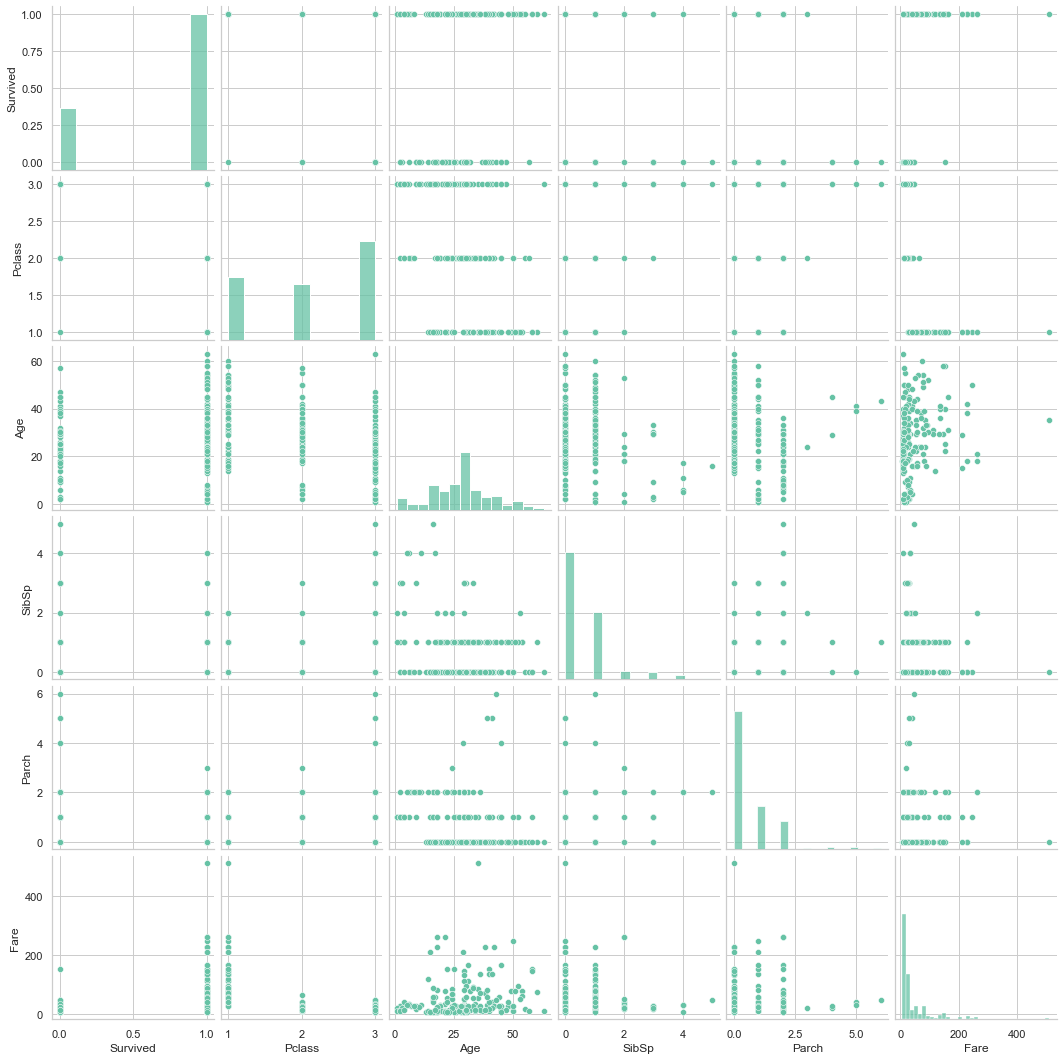

In [9]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.pairplot(data=train_female)

В строке 'Survived' явно выделяется график, связанный с ценой билета.

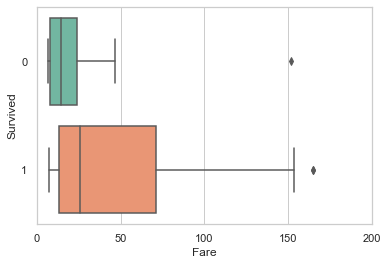

In [10]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.boxplot(data=train_female, y='Survived', x='Fare', orient='h')
    plt.xlim(0, 200)

Посмотрим на долю выживших с ценой билета большей конкретного числа.

In [11]:
train_female[train_female['Fare'] > 20]['Survived'].mean()

0.8245614035087719

Построим соответствующий график

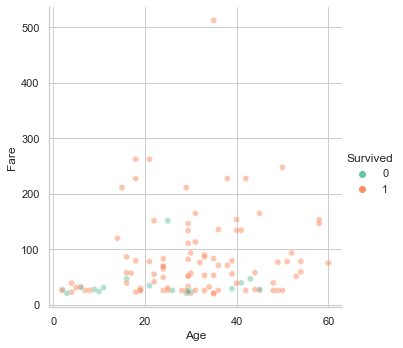

In [12]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    train_female_20 = train_female[train_female['Fare'] > 20]
    sns.relplot(data=train_female_20, hue='Survived',
                x='Age', y='Fare', alpha=0.5)

Видно, что если цена билета была выше 20 условных единиц, то шанс выжить относительно высокий.

Посмотрим на долю выживших с точки зрения класса пассажирок.

In [13]:
train_female_12 = train_female[train_female['Pclass'] < 3]
train_female_12['Survived'].mean()

0.9663865546218487

Построим соответствующий график

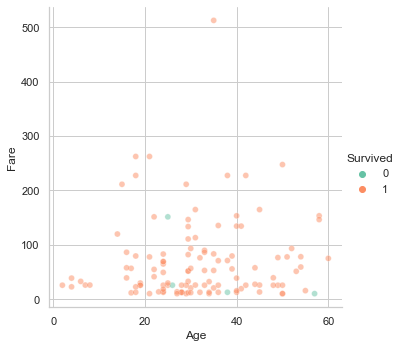

In [14]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.relplot(data=train_female_12, hue='Survived',
                x='Age', y='Fare', alpha=0.5)

При рассмотрении 1 и 2 класса вероятность для женщины очень высока. Посмотрим теперь на 3 класс:

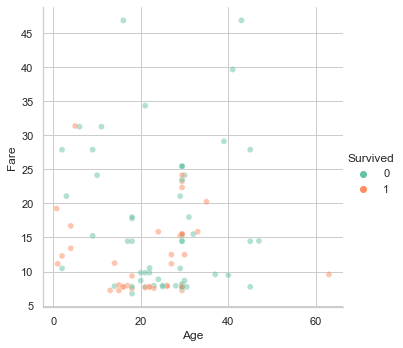

In [15]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    train_female_3 = train_female[train_female['Pclass'] == 3]
    sns.relplot(data=train_female_3, hue='Survived', x='Age', y='Fare',
                alpha=0.5)

Трудно что-то точное сказать. Посмотрим на другие характеристики с оговоркой на 3 класс:

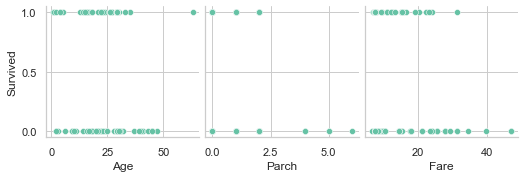

In [16]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.pairplot(data=train_female_3, x_vars=['Age', 'Parch', 'Fare'],
                 y_vars='Survived')

Возраст:

In [17]:
print(train_female_3[train_female_3['Age'] <= 35]['Survived'].mean())
print(train_female_3[train_female_3['Age'] > 35]['Survived'].mean())

0.45555555555555555
0.1


Количетво детей и родителей:

In [18]:
print(train_female_3[train_female_3['Parch'] < 3]['Survived'].mean())
print(train_female_3[train_female_3['Parch'] >= 3]['Survived'].mean())

0.4421052631578947
0.0


Цена билета:

In [19]:
print(train_female_3[train_female_3['Fare'] <= 20]['Survived'].mean())
print(train_female_3[train_female_3['Fare'] > 20]['Survived'].mean())

0.4805194805194805
0.21739130434782608


Попробуем пересечь все три признака:

In [20]:
train_female_3_mix = train_female_3[train_female_3['Age'] <= 35]
train_female_3_mix = train_female_3_mix[train_female_3_mix['Parch'] < 3]
train_female_3_mix = train_female_3_mix[train_female_3_mix['Fare'] <= 20]
train_female_3_mix['Survived'].mean()

0.5070422535211268

Возраст и количество детей или родителей влияет в положительную сторону, но слабо.  

Проведём теперь аналогичные рассуждения с выборкой мужчин:

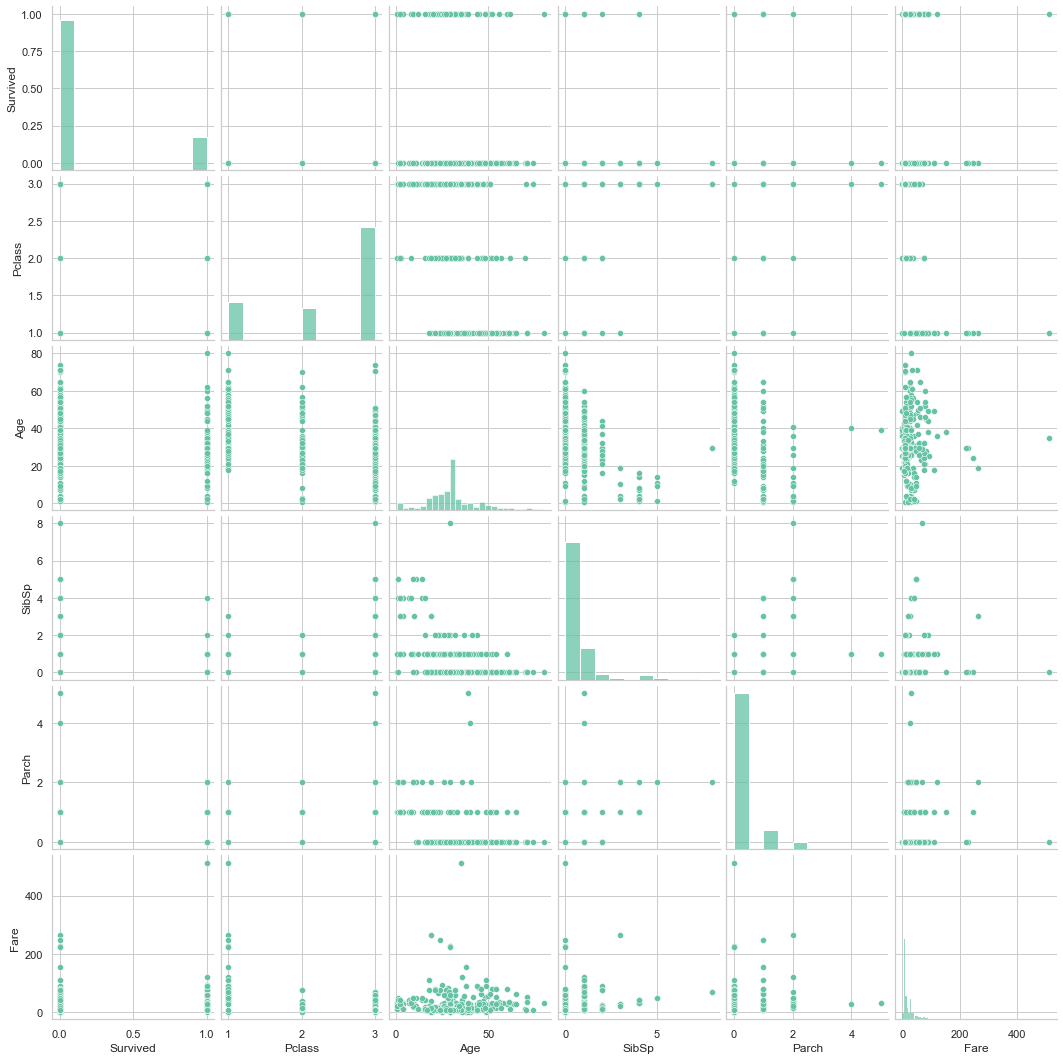

In [21]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.pairplot(data=train_male)

По колонке 'Survived' уже трудно что-то сказать. Это и не удивительно, когда в среднем выжил только каждый пятый.

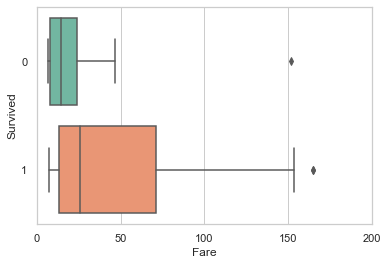

In [22]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.boxplot(data=train_female, y='Survived', x='Fare', orient='h')
    plt.xlim(0, 200)

Посмотрим на долю выживших с ценой билета большей конкретного числа.

In [23]:
train_male[train_male['Fare'] > 25]['Survived'].mean()

0.29838709677419356

Цена билета всё так же сильно влияет. Доля выживших увеличилась в полтора раза, хотя всё равно остаётся ниже половины.

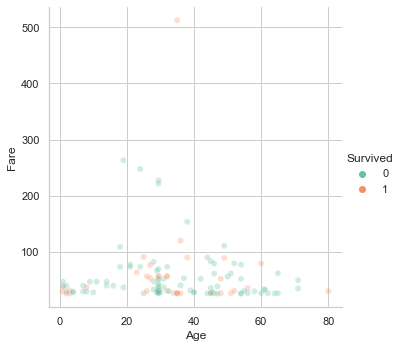

In [24]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    train_male_25 = train_male[train_male['Fare'] > 25]
    sns.relplot(data=train_male_25, hue='Survived',
                x='Age', y='Fare', alpha=0.3)

Попробуем теперь снова посмотреть на класс пассажира.

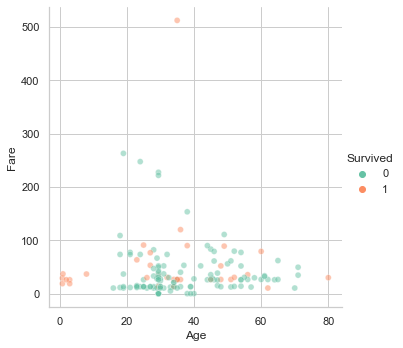

In [25]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    train_male_12 = train_male[train_male['Pclass'] < 3]
    sns.relplot(data=train_male_12, hue='Survived',
                x='Age', y='Fare', alpha=0.5)

Посмотрим отдельно на 3 класс:

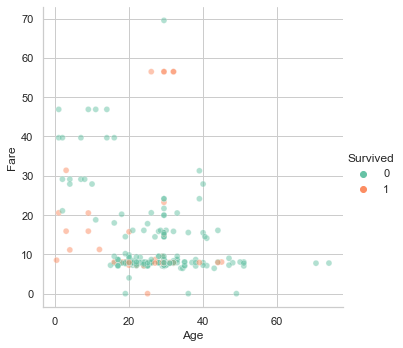

In [26]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    train_male_3 = train_male[train_male['Pclass'] == 3]
    sns.relplot(data=train_male_3, hue='Survived',
                x='Age', y='Fare', alpha=0.5)

Соответственно доля выживших.

In [27]:
train_male_12['Survived'].mean()

0.23076923076923078

Трудно что-то сказать по графику. Да и доля выживших близка к той, которую мы получили изначально, просто отделив мужчин от женщин. Значит в случае мужчин лучше смотреть на цену билета, чем на класс. Хотя на двух последних графиках выделяются дети. Посмотрим на возраст:  

In [28]:
print(train_male[train_male['Age'] > 10]['Survived'].mean())
print(train_male[train_male['Age'] <= 10]['Survived'].mean())

0.15567282321899736
0.5384615384615384


Возраст в 10 лет оказывается хорошим мерилом. Выживает каждый второй мальчик.

#### 3. Классификация

На основе проведенного исследования предложите два разных правила в виде решающего дерева, пример которого можете посмотреть в презентации с первой лекции (классификация котиков). Никакие статистические методы использовать не требуется, только логику и графики.

В данной задаче достаточно, если первое дерево будет иметь максимальную глубину 2, а второе &mdash; глубину 1, и при этом не является поддеревом первого. *Примечание*: дерево из одного листа имеет глубину 0.

**Дерево 1:**  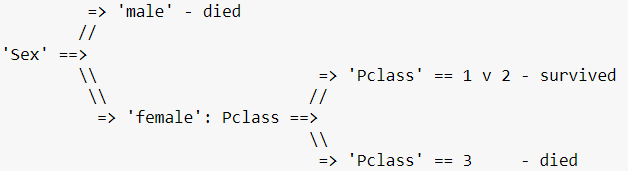

**Дерево 2:**  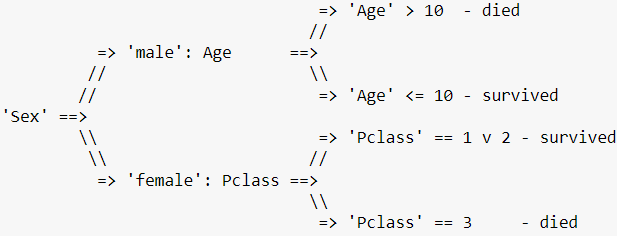

Реализуйте полученные деревья по шаблону

Дерево 1: 

In [29]:
def tree1(features):
    '''
    Предсказание целевого признака для данных features — pandas-таблица данных.
    Возвращает pandas.Series с теми же индексами, что и у features.
    '''
    if (features['Sex'] == 'male'):
        predicted = 0
    else:
        if (features['Pclass'] < 3):
            predicted = 1
        else:
            predicted = 0
    return predicted

Дерево 2:

In [30]:
def tree2(features):
    '''
    Предсказание целевого признака для данных features — pandas-таблица данных.
    Возвращает pandas.Series с теми же индексами, что и у features.
    '''
    if (features['Sex'] == 'male'):
        if (features['Age'] <= 10):
            predicted = 1
        else:
            predicted = 0
    else:
        if (features['Pclass'] < 3):
            predicted = 1
        else:
            predicted = 0
    return predicted

#### 4. Качество

Вспомним, что у нас имеется тестовая часть выборки. Самое время ее использовать для того, чтобы оценить, насколько хорошими получились деревья. Предложите какой-нибудь критерий качества.

*Замечание*. Не стоит пытаться искать, какие критерии существуют. В данном случае легко предложить адекватный критерий. Стандартные критерии мы разберем позже, но для начала лучше подумать самостоятельно.

**Критерий:**

Для каждого элемента тествой выборки определим результат применения решающего дерева. Составим соответствующую колонку с 0 и 1, сопоставим её исходной, сделаем колонку результатов: True - если значения в двух столбцах совпадают, False - иначе. Критерием будем считать среднее по столбцу результатов - процент предсказания

Реализуйте данный критерий по шаблону

In [31]:
def criteria1(target, predicted):
    '''
    Вычисление критерия качества для предсказания predicted,
    если истинные значения — target.
    Возвращает одно вещественное число.
    '''
    target_copy = target.copy()
    target_copy['Survived'] = target_copy.apply(lambda x: tree1(x), axis=1)
    target_copy['True'] = predicted.to_frame()
    target_copy['right'] = target_copy['Survived'] == target_copy['True']

    return target_copy['right'].mean()

In [32]:
def criteria2(target, predicted):
    '''
    Вычисление критерия качества для предсказания predicted,
    если истинные значения — target.
    Возвращает одно вещественное число.
    '''
    target_copy = target.copy()
    target_copy['Survived'] = target_copy.apply(lambda x: tree2(x), axis=1)
    target_copy['True'] = predicted.to_frame()
    target_copy['right'] = target_copy['Survived'] == target_copy['True']

    return target_copy['right'].mean()

Посчитайте качество полученных ранее деревьев.

*Примечание.* Полученные значения не влияют на оценку по задание. Оценивается только корректность и обоснованность решения, а также графики и выводы.

Применим первое дерево.

In [33]:
criteria1(test_df_features, test_df_target)

0.7340823970037453

Применим второе дерево.

In [34]:
criteria2(test_df_features, test_df_target)

0.7453183520599251

**5. Метод ближайшего соседа**

В домашнем задании 1 вы уже реализовали функцию поиска ближайших соседей. Теперь давайте применим ее для решения нашей текущей задачи. 

Реализуйте функцию, которая для каждого объекта тестового набора данных найдет $k$ ближайших соседей из обучающего набора данных, и в качестве ответа возьмет наиболее часто встречающееся значение целевого признака среди найденных соседей. Обратите внимание, что соседей необходимо искать только среди объектов обучающего набора данных.

In [35]:
def knn(test_features, train_features, train_target, k=1):
    '''
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    на основе обучающего набора данных train_features, train_target.
    Возвращает pandas.Series с теми же индексами, что и у features.
    Число k -- количество соседей.
    '''
    train_f = train_features.copy()
    train_f = train_f.replace(['male'], 0)  # Переведём пол в числа
    train_f = train_f.replace(['female'], 1)

    f = test_features.copy()
    f = f.replace(['male'], 0)  # Переведём пол в числа
    f = f.replace(['female'], 1)

    A = np.array(train_f)  # k ближайших соседей
    B = np.array(f)
    C = np.sqrt(((A[:, np.newaxis, :] - B[np.newaxis, :, :]) ** 2).sum(axis=2))

    D = pd.DataFrame((np.argsort(C.T))[:, :k])

    # При перемножении матриц исходные индексы не сохранились
    # Сбросим индексы у тренировочной выборки для соответствия
    E = train_target.copy().reset_index(drop=True)

    # Сопоставим индексам в таблице значения
    D = D.apply(lambda x: x.apply(lambda y: E.loc[y]))

    # Получим соответствующие результаты для каждого элемента
    res = D.sum(axis=1) > k - D.sum(axis=1)
    res = res.to_frame(name="Survived")

    return res.set_index(test_df_target.index)

In [36]:
def criteria_knn(test_features, train_features, test_target,
                 train_target, k=1):
    '''
    Функция оценки качества предсказания по k ближайшим соседям
    '''
    target_copy = test_features.copy()
    target_copy['Survived'] = knn(test_features, train_features, train_target,
                                  k)
    target_copy['True'] = test_target.to_frame()
    target_copy['right'] = target_copy['Survived'] == target_copy['True']

    return target_copy['right'].mean()

Посчитайте значение предложенного ранее критерия качества для метода ближайшего соседа для значений $k$ от 1 до 10. Постройте график зависимости критерия качества от $k$. Как вы можете пояснить полученные результаты?

In [37]:
knn_df = pd.DataFrame([i + 1 for i in range(10)], columns=['k_meaning'])
knn_df['score'] = knn_df['k_meaning'].apply(lambda x:
                                            criteria_knn(test_df_features,
                                                         train_df_features,
                                                         test_df_target,
                                                         train_df_target, x))

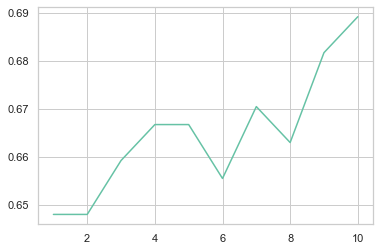

In [38]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    plt.plot(knn_df['k_meaning'], knn_df['score'])

При увеличении количества соседей точность растёт, но не линейно. При большом количестве соседей она растёт довольно быстро, хотя при значениях 6 и 8 падает. Думаю, это может происходить из-за случайности выборки. Резкий же рост, наверно, происходит из-за уменьшения вклада в результат одного элемента выборки.

#### 6. Выводы

* На целевой признак в первую очередь сильно влияет пол пассажира. Женщины выживают в разы чаще, чем мужчины.
* На выживаемость женщин влияют цена билета и класс. Женщины из 1 и 2 класса выживают практически всегда. В противном случае нужно рассматривать другие признаки, комбинировать их, чтобы можно было сделать вывод о выживаемости.
* На выживаемость мужчин влияет возраст. Выживаемость детей до 10 лет в 2.5 раза выше по сравнению с общей долей выживших
* Остальные признаки не оказывают явного влияния на целевой признак, поэтому далее выделять результативные выборки трудно.
* Решающее дерево даёт более точный результат, если увеличивать количество признаков в его узлах
* При увеличении количества соседей в методе knn точность предсказания увеличивается, но при малых k точность может и падать

In [39]:
import plotly
import plotly.graph_objects as go
import plotly.express as px


---
### <font color="orange"><i>Сложная часть</i></font>

### Задача 2

<a target="_blank" href="yelp.com">Yelp</a> — веб-сайт для поиска на местном рынке услуг, например ресторанов или парикмахерских, с возможностью добавлять и просматривать рейтинги и обзоры этих услуг. Для популярных бизнесов имеются сотни обзоров. Для обозревателей на сайте предусмотрены элементы социальной сети.

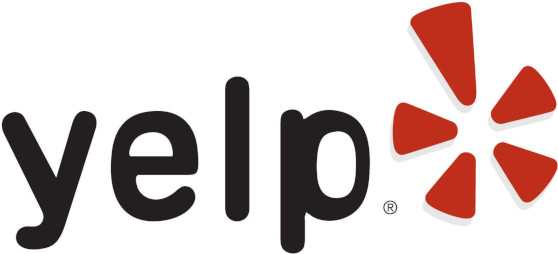

_____________

Вам предоставляется следующая информация о компаниях на Yelp:

Файл `yelp_business.csv`:
* `business_id` — уникальный идентификатор компании;
* `name` — имя компании;
* `address`, `city`, `state` — месторасположении компании;
* `latitude`, `longitude` — географические координаты;
* `categories` — категории услуг компании.

Файл `yelp_review.csv`, содержащий оценки пользователей:
* `business_id` — идентификатор компании, соответствующий файлу `yelp_business.csv`;
* `stars` — поставленная пользователем оценка от 1 до 5.

В целях сокращения объема файла, текстовые отзывы пользователей не были включены.

Оригинальную версию датасета в формате `json` можно посмотреть по <a target="_blank" href="https://www.kaggle.com/yelp-dataset/yelp-dataset/data">ссылке</a>.

_____________

**Что нужно сделать:** 

* Найти город с наибольшим количеством компаний;
* Для этого города определить районы с наиболее качественными услугами. <a target="_blank" href="https://yandex.ru/company/researches/2017/msk_mobile_map">Пример</a> с несколько другой задачей.
* А также найти рестораны с наилучшими отзывами.

------

#### Город с наибольшим количеством компаний

Загрузите данные из файла `yelp_business.csv` с помощью функции `pd.read_csv`. Посмотрите на первые несколько строк с помощью метода `head`.

In [40]:
df = pd.read_csv('yelp_business.csv')
df.drop(labels=['Unnamed: 0', 'neighborhood', 'postal_code', 'is_open'], axis=1,
        inplace=True)
df.dropna(how='any', inplace=True)
df.head()

,business_id,name,address,city,state,latitude,longitude,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""","""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,33.330690,-111.978599,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""","""3101 Washington Rd""",McMurray,PA,40.291685,-80.104900,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""","""6025 N 27th Ave, Ste 1""",Phoenix,AZ,33.524903,-112.115310,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""","""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,33.383147,-111.964725,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",Cuyahoga Falls,OH,41.119535,-81.475690,American (New);Nightlife;Bars;Sandwiches;Ameri...


Найдите пять городов, по которым присутствует информация о наибольшем количестве компаний. В таблице должен быть указан город (название) и количество компаний в этом городе.

*Подсказка.* Для выполнения стоит воспользоваться методами `groupby`, `count`, `sort_values`, `head`.

In [41]:
city_businesses = df.groupby('city').count()
city_businesses = city_businesses['business_id'].to_frame(name='business_id')
city_businesses.sort_values(by='business_id', ascending=False).head(5)

,business_id
city,
Las Vegas,26775
Phoenix,17213
Toronto,17205
Charlotte,8553
Scottsdale,8228


Пусть `N` &mdash; город с наибольшим количеством компаний. Оставьте в таблице только записи, соответствующие городу `N`. Нанесите все эти компании на график, в котором по оси $x$ отметьте долготу, а по оси $y$ &mdash; широту.

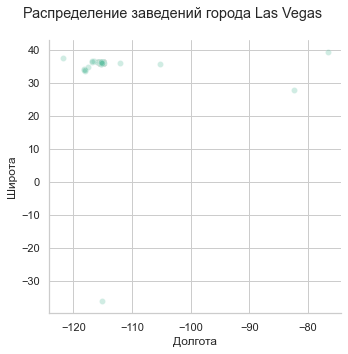

In [42]:
df = df[df['city'] == 'Las Vegas']

with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    d = sns.relplot(data=df, x='longitude', y='latitude', alpha=0.3)

    d.fig.suptitle('Распределение заведений города Las Vegas ')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')

Сам город находится в сгустке точек. Есть какие-то компании, которые приписаны к этому городу, но находятся далеко от него. Избавьтесь от них, подобрав некоторые границы значений широты и долготы. Изобразите все компании на новом графике. На этом графике должны выделяться некоторые улицы. 

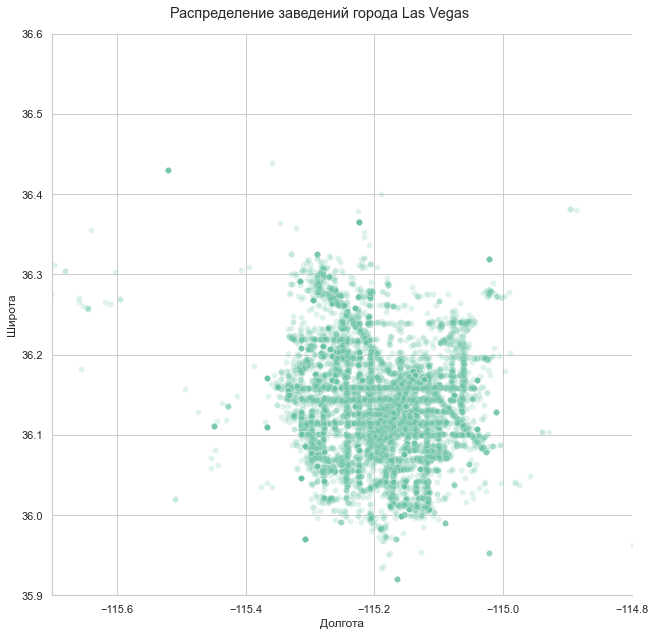

In [43]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    d = sns.relplot(data=df, x='longitude', y='latitude', alpha=0.2,
                    height=9, aspect=1)

    d.fig.suptitle('Распределение заведений города Las Vegas ')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    d.fig.tight_layout()
    plt.xlim(-115.7, -114.8)
    plt.ylim(35.9, 36.6)

Разберитесь с тем, как подгрузить интерактивную карту города в качестве фона графика. Можно пойти двумя следующими способами.
1. Изучить <a href="https://miptstats.github.io/courses/python/11_plotly.html" target="_blank">материалы</a> по библиотеке <a href="https://plotly.com/python/" target="_blank"><b>Plotly</b></a>. Возможно, потребуется также заглянуть в документацию.
1. Поразбираться с библиотекой <a href="https://github.com/python-visualization/folium" target="_blank"><b>Folium</b></a>. Посмотрите множество <a href="https://nbviewer.org/github/python-visualization/folium/tree/main/examples/" target="_blank">примеров</a>, может также помочь <a href="https://proglib.io/p/python-web-map" target="_blank">статья на русском</a>.

*Внимание!* Интерактивная карта может не сохраниться в ноутбуке, а если сохранится, то вес ноутбука может превзойти 20 Мб. Рекомендуется сохранить карту в html и отправить ее отдельным файлом в бот.

In [44]:
# Накладываем данные на карту
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", size_max=0.1,
                        zoom=9.7, opacity=0.3, width=800, height=700)
fig.update_layout(mapbox_style="open-street-map")
fig.write_html('map.html')  # сохраняем график в html

Если все получилось, вы молодцы! Далее в этой задаче тоже можно делать интерактивные карты.

#### Оценки компаний

Для выполнения задания нужно посчитать среднюю оценку каждой компании, а также количество выставленных оценок.

Загрузите таблицу оценок `yelp_review.csv`.

In [45]:
df_review = pd.read_csv('yelp_review.csv')
df_review.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
df_review.head()

,business_id,stars
0,AEx2SYEUJmTxVVB18LlCwA,5
1,VR6GpWIda3SfvPC-lg9H3w,5
2,CKC0-MOWMqoeWf6s-szl8g,5
3,ACFtxLv8pGrrxMm6EgjreA,4
4,s2I_Ni76bjJNK9yG60iD-Q,4


В подгруженной таблице оценок оставьте только компании города `N`. Для этого установите значения `business_id` в качестве индекса у таблицы оценок и воспользуйтесь методом `loc`. 

*Подсказка.* Чтобы индекс снова сделать полем таблицы, можно воспользоваться методом `reset_index`.

In [46]:
df_review = df_review.set_index('business_id')
df_review = df_review.loc[df['business_id']].reset_index()

Теперь посчитайте среднюю оценку каждой компании, а также количество выставленных компании оценок. 

*Подсказка.* Помочь в этом могут функции `groupby` и `aggregate([np.mean, np.size])`.

In [47]:
df_review = df_review.groupby(by=['business_id']).aggregate([np.mean, np.size])
df_review

stars      
                            mean  size
business_id                           
--9e1ONYQuAa-CB_Rrw7Tw  4.088904  1451
--DdmeR16TRb3LsjG0ejrQ  3.200000     5
--WsruI0IGEoeRmkErU5Gg  4.928571    14
--Y7NhBKzLTbNliMUX_wfg  4.875000     8
--e8PjCNhEz32pprnPhCwQ  3.473684    19
...                          ...   ...
zzOo9n22fBbKAhbSpMzggA  3.230769    26
zzXuJF6UUT1kgTyCsmgDmQ  5.000000     4
zzjqFOujmM9surbMANZ_ag  5.000000     3
zzsKbL1KMNJqazSqBXskxQ  3.666667     6
zzzaIBwimxVej4tY6qFOUQ  3.432432    37

[26775 rows x 2 columns]

Назовите колонки таблицы красивыми именами, изменив `<имя таблицы>.columns`, после чего напечатайте несколько строк полученной таблицы. Красивые имена &mdash; то, что будет понятно простому человеку при чтении ваших результатов. Как именно их назвать &mdash; задача аналитика, то есть в данном случае ваша :)

In [48]:
df_review.columns = ['Средняя оценка', 'Количество оценок']
df_review.head()

,Средняя оценка,Количество оценок
business_id,,
--9e1ONYQuAa-CB_Rrw7Tw,4.088904,1451
--DdmeR16TRb3LsjG0ejrQ,3.200000,5
--WsruI0IGEoeRmkErU5Gg,4.928571,14
--Y7NhBKzLTbNliMUX_wfg,4.875000,8
--e8PjCNhEz32pprnPhCwQ,3.473684,19


Соедините две полученные ранее таблицы по компаниям города `N` в одну.
Для этого сначала установите поле `business_id` в качестве индекса в обеих таблицах с помощью `set_index`. В одной из них это уже должно было быть сделано.
В полученной таблице должны получится поля `latitude`, `longitude`, `categories`, `name`, `stars`, `count`.

*Подсказка.* Соединение таблиц можно выполнить с помощью `join`.
Индексы у этих таблиц одинаковые, так что тип джойна не имеет значения.

In [49]:
df = df.set_index('business_id')
df = df.join(df_review)
df.head()

,name,address,city,state,latitude,longitude,categories,Средняя оценка,Количество оценок
business_id,,,,,,,,,
kCoE3jvEtg6UVz5SOD3GVw,"""BDJ Realty""","""2620 Regatta Dr, Ste 102""",Las Vegas,NV,36.207430,-115.268460,Real Estate Services;Real Estate;Home Services...,4.000000,5
OD2hnuuTJI9uotcKycxg1A,"""Soccer Zone""","""7240 W Lake Mead Blvd, Ste 4""",Las Vegas,NV,36.197484,-115.249660,Shopping;Sporting Goods,1.444444,9
VBHEsoXQb2AQ76J9l8h1uQ,"""Alfredo's Jewelry""","""5775 S Eastern, Ste 103""",Las Vegas,NV,36.085051,-115.119421,Shopping;Jewelry;Watch Repair;Local Services,4.739130,23
1Jp_hmPNUZArNqzpbm7B0g,"""Task Electric""","""7260 Cimarron Rd, Ste 130""",Las Vegas,NV,36.056382,-115.269332,Home Services;Lighting Fixtures & Equipment;Lo...,4.450000,20
DPQnTnNw2PJj7DdENM98Cw,"""Star Nursery""","""5340 Boulder Hwy""",Las Vegas,NV,36.105196,-115.056880,Nurseries & Gardening;Home & Garden;Shopping,3.680000,25


Изобразите все компании на графике, раскрасив точку в цвет, оттенок которого соответствует средней оценке компании. Прозрачность точки выставляйте не более $0.3$.

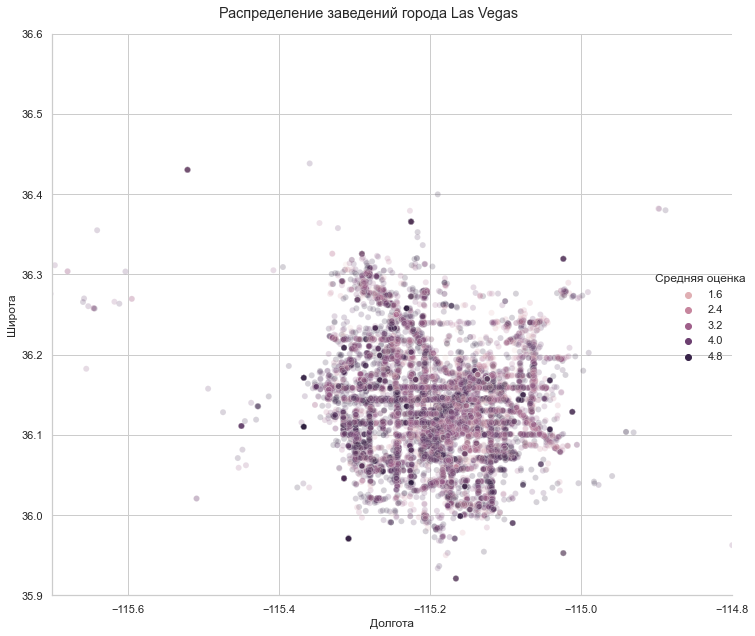

In [50]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    d = sns.relplot(data=df, x='longitude', y='latitude', alpha=0.2, height=9,
                    aspect=1, hue='Средняя оценка')

    d.fig.suptitle('Распределение заведений города Las Vegas ')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    d.fig.tight_layout()
    plt.xlim(-115.7, -114.8)
    plt.ylim(35.9, 36.6)

Чтобы получить районы города, то есть разделить город на "клетки", округлите значения широты и долготы, подобрав оптимальный размер района. 

*Подсказка.* Например, можно сделать так
`np.round(долгота*4, decimals=1)*0.25`.

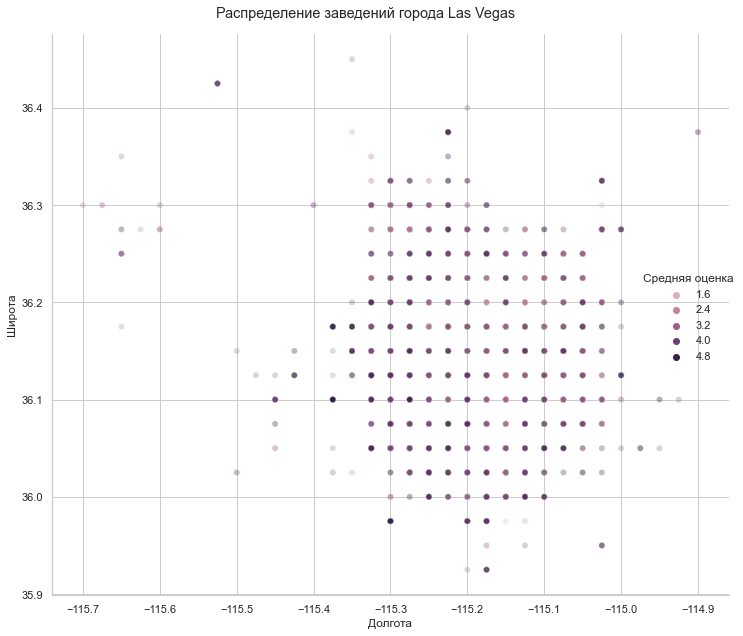

In [51]:
df_copy = df.copy()  # Избавимся от выбросов по координатам
df_copy = df_copy[35.9 <= df_copy['latitude']]
df_copy = df_copy[df_copy['latitude'] <= 36.6]
df_copy = df_copy[-115.7 <= df_copy['longitude']]
df_copy = df_copy[df_copy['longitude'] <= -114.8]

# Округлим
df_copy['latitude'] = np.round(df_copy['latitude'] * 4, decimals=1) * 0.25
df_copy['longitude'] = np.round(df_copy['longitude'] * 4, decimals=1) * 0.25

with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    d = sns.relplot(data=df_copy, x='longitude', y='latitude', alpha=0.2,
                    height=9, aspect=1, hue='Средняя оценка')

    d.fig.suptitle('Распределение заведений города Las Vegas ')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')

Для получения средней оценки компании по району постройте сводную таблицу при помощи `pd.pivot_table`, взяв в качестве индексов и колонок округленные широту и долготу, а в качестве значений &mdash; оценки. Аггрегирующей функцией является среднее.

Изобразите полученную таблицу при помощи `sns.heatmap`.

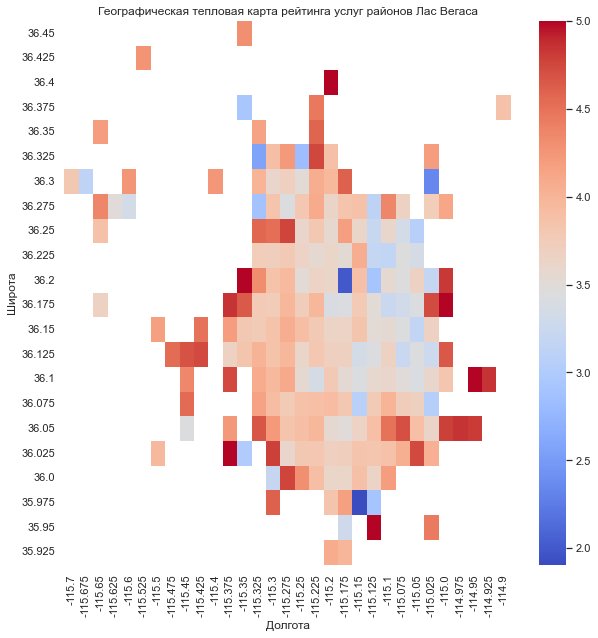

In [52]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    pivot_table = pd.pivot_table(df_copy, index='latitude', aggfunc='mean',
                                 columns='longitude', values='Средняя оценка')
    fig, ax = plt.subplots(figsize=(10, 10))
    a = sns.heatmap(pivot_table, cmap='coolwarm')
    a.invert_yaxis()

    plt.title('Географическая тепловая карта рейтинга услуг районов Лас Вегаса')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')

Полученный график имеет ряд недостатков. Во-первых, не очень правильно судить о районе, если в нем мало компаний. Во-вторых,  на графике цветовая гамма автоматически подстроилась под минимальное и максимальное значения оценки.

Почему эти недостатки могут быть существенными?

**Ответ:** Причин, почему в  районе может быть мало компаний может быть несколько и необязательно они могут зависить от качества самих заведений или благоприятности района. Например, в районе может находиться электростанция, промзона(хотя в случае Лас Вегаса вряд ли), природные препятствия, дорожные магистрали, которые занимают много площади, соответственно не так много офисов там может поместиться, или это может быть жилой район, где живот работники тех самых компаний, там опять же наврядли будет много компаний. В случае автоматической подстройки цветового спектра можно сказать, что если в районе всего 2 заведения и у каждого по одному 5-звёздочному отзыву, то этот район будет сильно выделяться на фоне других, поэтому имеет смысл отбросить компании и районы с малым числом отзывов.

Оставьте районы, в которых имеется информация о не менее $30$ компаний. Постройте новый график районов, использовав параметры `vmin` и `vmax` у функции `sns.heatmap`.

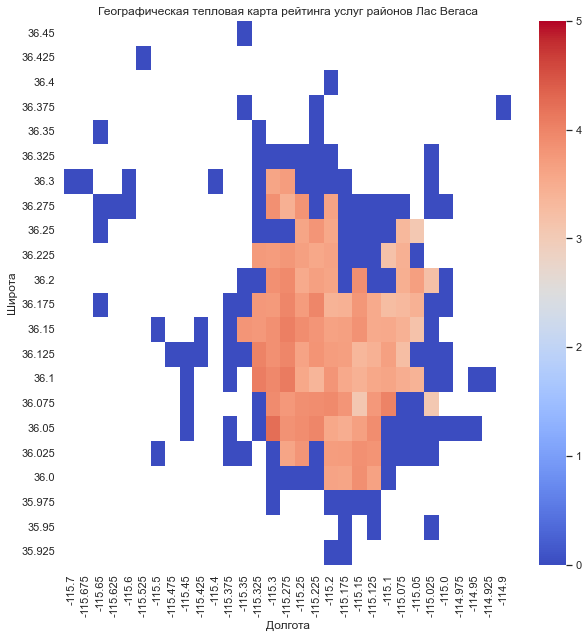

In [53]:
# Избавимся от выбросов
pivot_table2 = pd.pivot_table(df_copy, index='latitude', columns='longitude',
                              values='Средняя оценка', aggfunc='count')
pivot_table2_bool = pivot_table2 >= 30
pivot_table2 = pivot_table2_bool * pivot_table

with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    a = sns.heatmap(pivot_table2, cmap='coolwarm', vmin=0, vmax=5)
    a.invert_yaxis()

    plt.title('Географическая тепловая карта рейтинга услуг районов Лас Вегаса')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')

Сравните полученный график с предыдущим и сделайте вывод.

**Вывод:** Действительно, с тепловой карты пропали районы с высокой оценкой. Теперь можно разглядеть "деловую" окраину и острова, которые окаймляют деловое ядро города. Сам центр стал более однорным, градиент стал более плавным. Получается, что избавившись от выбросов, мы получили более ясную и адекватную тепловую карту.

#### Рестораны

Будем считать компанию рестораном, если в поле `categories` *содержится* слово `restaurant`. Обратите внимание, что в анализе данных часто нет четкого формата данных. Например, данное слово может быть написано как с большой буквы, так и с маленькой; может как разделяться `;`, так и не разделяться. При возникновении недопонимания стоит посмотреть данные.

Составьте таблицу, в которой будет информация о всех ресторанах города `N`, для которых имеется не менее $5$ отзывов. Далее постройте heatmap-график районов, в котором каждому району сопоставьте среднюю оценку по ресторанам этого района. Рассматривайте только те районы, в которых есть не менее $10$ ресторанов, для каждого из которых есть не менее $5$ отзывов.

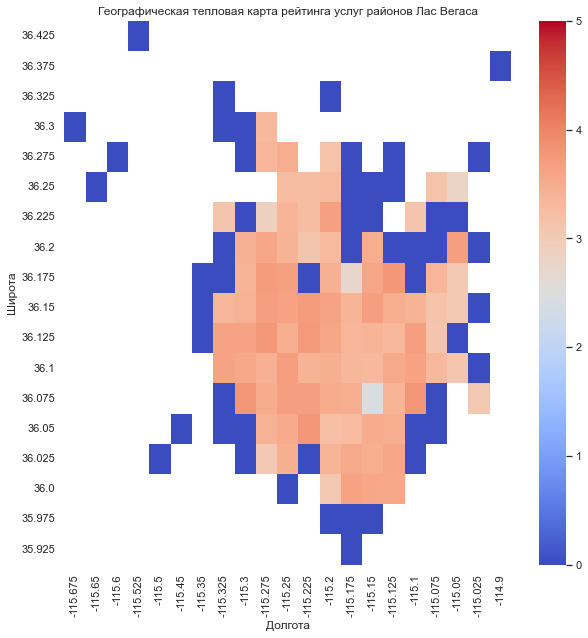

In [54]:
# Отберём необходимые для дальнейшей задачи данные
df_restaurant = df_copy[df_copy["categories"].str.contains("Restaurant")]
df_restaurant = df_restaurant[df_restaurant['Количество оценок'] >= 5]

pivot_table_rest = pd.pivot_table(df_restaurant, index='latitude',
                                  aggfunc='mean', columns='longitude',
                                  values='Средняя оценка')

pivot_table_rest2 = pd.pivot_table(df_restaurant, index='latitude',
                                   aggfunc='count', columns='longitude',
                                   values='Средняя оценка')

pivot_table_rest2_bool = pivot_table_rest2 >= 10
pivot_table_rest2 = pivot_table_rest2_bool * pivot_table_rest

with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    a = sns.heatmap(pivot_table_rest2, cmap='coolwarm', vmin=0, vmax=5)
    a.invert_yaxis()

    plt.title('Географическая тепловая карта рейтинга услуг районов Лас Вегаса')
    d.fig.tight_layout()
    plt.xlabel('Долгота')
    plt.ylabel('Широта')

Чем полезны ограничения снизу на количество отзывов для ресторана и количество ресторанов в районе?

**Ответ:** Такие ограничения позволяют нам снова избавиться от выбросов. Мы хотим узнать какие-то статистические закономерности, информацию в общем о городе, а выбросы будут только искажать данные. Если в районе 1 ресторан с 3 отзывами в 5 звёзд, то такой район будет самым лучшим, но почему в этом районе так мало ресторанов и почему так мало оценок - довольно важные вопросы в этом случае. Поэтому для эффективного анализа мы удаляем рестораны с, получается, низкой пропускаемостью и районы с маленьким числом ресторанов

Кот Василий из города `N` очень придирчив к выбору ресторана. Он доверяет только ресторанам с высоким рейтингом, который основывается на большом количестве отзывов. Напечатайте в виде таблицы информацию $10$ ресторанах с самым большим рейтингом в порядке убывания рейтинга. Для каждого из этих ресторанов должно быть не менее $50$ отзывов. По каждому ресторану необходимо вывести следующую информации: название ресторана, средняя оценка, количество отзывов, географические координаты, категории.

In [55]:
# Отберём рестораны, которые угождают Коту Василию
df_restaurant = df[df["categories"].str.contains("Restaurant")]
df_restaurant = df_restaurant.dropna(how='any')
df_restaurant['Средняя оценка'] = np.round(df_restaurant['Средняя оценка'] * 4,
                                           decimals=1) * 0.25
df_restaurant = df_restaurant[df_restaurant['Количество оценок'] >= 50]

# Посмотрим на лучшие по отзывам рестораны Лас Вегаса
top = df_restaurant.sort_values(by='Средняя оценка', ascending=False).head(10)
top = top.drop(columns=['address', 'city', 'state'], axis=1)
top[['name', 'Средняя оценка', 'Количество оценок', 'latitude', 'longitude',
    'categories']].reset_index(drop=True)

,name,Средняя оценка,Количество оценок,latitude,longitude,categories
0,"""Lip Smacking Foodie Tours""",4.975,179,36.114537,-115.172678,Food Tours;Restaurants;Event Planning & Servic...
1,"""Pepito Shack""",4.900,65,36.152477,-115.151945,Restaurants;Burgers;Food Stands;Sandwiches;Hot...
2,"""Bosa Boba Cafe""",4.900,55,36.125960,-115.184846,Vietnamese;Bubble Tea;Sandwiches;Food;Coffee &...
3,"""Garden Grill""",4.875,91,36.166783,-115.286197,Tacos;Street Vendors;Farmers Market;Vegetarian...
4,"""Brew Tea Bar""",4.850,1165,36.054195,-115.242443,Cafes;Tea Rooms;Food;Bubble Tea;Restaurants;De...
5,"""El Frescos Cocina Mexicana""",4.825,191,36.098527,-115.148446,Caterers;Mexican;Restaurants;Food;Event Planni...
6,"""Poppa Naps BBQ""",4.825,104,36.116549,-115.088115,Food Stands;Hot Dogs;Caterers;Restaurants;Amer...
7,"""Zenaida's Cafe""",4.825,180,36.101741,-115.100359,Restaurants;Breakfast & Brunch;Cafes
8,"""Blaqcat Ultra Hookah Lounge""",4.800,63,36.159742,-115.232738,Adult Entertainment;Lounges;Hookah Bars;Restau...
9,"""California Sushi Burrito""",4.800,57,36.125636,-115.202487,Asian Fusion;Fast Food;Restaurants;Japanese;Po...


Нанесите на карту все рестораны со средней оценкой не менее $4.7$, которая посчитана по не менее $50$ отзывам. Отдельным цветом отметьте 10 ресторанов, которые вы получили ранее.

In [56]:
# Отберём соответствующие рестораны
df_restaurant_top = df_restaurant[df_restaurant['Средняя оценка'] >= 4.7]
df_restaurant_top = df_restaurant_top.sort_values(by='Средняя оценка',
                                                  ascending=False)

# Выделим 10 самых лучших
df_restaurant_top['top'] = [i for i in range(len(df_restaurant_top))]
df_restaurant_top['top'] = df_restaurant_top['top'] < 10
df_restaurant_top = df_restaurant_top.replace(True, 'top')
df_restaurant_top = df_restaurant_top.replace(False, 'others')

# Изобразим данные на карте
fig = px.scatter_mapbox(df_restaurant_top, color='top', lat="latitude",
                        lon="longitude", size_max=0.1, zoom=9.7, opacity=1,
                        width=800, height=700)
fig.update_layout(mapbox_style="open-street-map")
fig.write_html('map_rest.html')  # сохраняем график в html

Охарактеризуйте кота Василия, а также сделайте общий вывод по задаче.

**Вывод:** 
* Кот Василий доверяет мнению большинства, не стремиться найти хороший ресторан среди малопопулярных. Он доверяет статистике, а не конкретным отзывам и оценкам.

* Выбросы в данных могут сильно влиять на получающиеся графики и, соответственно, на результаты исследования.  

* В Лас Вегасе очень развит рынок услуг. Вероятно, это связано с тем, что это город, экономика которого зиждется на отелях, казино и прочих развлечениях. 

* Большая часть ресторанов, особенно в группе с рейтингом не менее 4.7 сосредоточена в южной половине города. Причём из последнего графика видно, что в юго-западной части города сосредоточена бОльшая их часть.

* Важную роль играет точность данных. При меньшей степени округления данных тепловая карта стала бы больше походить на карту, где рестораны были отмечены точками. Тогда сложно было бы выделить районы города и что либо о них говорить.
